In [671]:
import polars as pl
# 列表示を省略しない
pl.Config.set_tbl_cols(-1)
# 行の表示を省略しない
pl.Config.set_tbl_rows(-1)
# df.selectで使用するExpr
import polars.selectors as cs

# 3章 顧客の全体像を把握する１０本ノック

ここでは、スポーツジムの会員データを使って顧客の行動を分析していきます。  
これまでと同様にまずはデータを理解し、加工した後、  
顧客の行動データを分析していきましょう。  
ここでは、機械学習に向けての初期分析を行います。

### ノック21：データを読み込んで把握しよう

In [634]:
uselog = pl.read_csv('use_log.csv')
print(len(uselog))
uselog.head()

197428


log_id,customer_id,usedate
str,str,str
"""L0000004901233…","""AS009373""","""2018-04-01"""
"""L0000004901233…","""AS015315""","""2018-04-01"""
"""L0000004901233…","""AS040841""","""2018-04-01"""
"""L0000004901233…","""AS046594""","""2018-04-01"""
"""L0000004901233…","""AS073285""","""2018-04-01"""


In [635]:
customer = pl.read_csv('customer_master.csv')
print(len(customer))
customer.head()

4192


customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
str,str,str,str,str,str,str,i64
"""OA832399""","""XXXX""","""C01""","""F""","""2015-05-01 00:…",null,"""CA1""",0
"""PL270116""","""XXXXX""","""C01""","""M""","""2015-05-01 00:…",null,"""CA1""",0
"""OA974876""","""XXXXX""","""C01""","""M""","""2015-05-01 00:…",null,"""CA1""",0
"""HD024127""","""XXXXX""","""C01""","""F""","""2015-05-01 00:…",null,"""CA1""",0
"""HD661448""","""XXXXX""","""C03""","""F""","""2015-05-01 00:…",null,"""CA1""",0


In [636]:
class_master = pl.read_csv('class_master.csv')
print(len(class_master))
class_master.head()

3


class,class_name,price
str,str,i64
"""C01""","""オールタイム""",10500
"""C02""","""デイタイム""",7500
"""C03""","""ナイト""",6000


In [637]:
campaign_master = pl.read_csv('campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


campaign_id,campaign_name
str,str
"""CA1""","""通常"""
"""CA2""","""入会費半額"""
"""CA3""","""入会費無料"""


### ノック22：顧客データを整形しよう

In [638]:
customer_join = (
    customer
    .join(other = class_master, on = "class", how = "left")
    .join(other = campaign_master, on="campaign_id", how="left")
)
customer_join.head()

customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
str,str,str,str,str,str,str,i64,str,i64,str
"""OA832399""","""XXXX""","""C01""","""F""","""2015-05-01 00:…",null,"""CA1""",0,"""オールタイム""",10500,"""通常"""
"""PL270116""","""XXXXX""","""C01""","""M""","""2015-05-01 00:…",null,"""CA1""",0,"""オールタイム""",10500,"""通常"""
"""OA974876""","""XXXXX""","""C01""","""M""","""2015-05-01 00:…",null,"""CA1""",0,"""オールタイム""",10500,"""通常"""
"""HD024127""","""XXXXX""","""C01""","""F""","""2015-05-01 00:…",null,"""CA1""",0,"""オールタイム""",10500,"""通常"""
"""HD661448""","""XXXXX""","""C03""","""F""","""2015-05-01 00:…",null,"""CA1""",0,"""ナイト""",6000,"""通常"""


In [639]:
print(len(customer))
print(len(customer_join))

4192
4192


In [640]:
customer_join.null_count().transpose(include_header = True)

column,column_0
str,u32
"""customer_id""",0
"""name""",0
"""class""",0
"""gender""",0
"""start_date""",0
"""end_date""",2842
"""campaign_id""",0
"""is_deleted""",0
"""class_name""",0


### ノック23：顧客データの基礎集計をしよう

In [641]:
customer_join.group_by("class_name").agg( pl.count("customer_id") )

class_name,customer_id
str,u32
"""オールタイム""",2045
"""ナイト""",1128
"""デイタイム""",1019


In [642]:
customer_join.group_by("campaign_name").agg( pl.count("customer_id") )

campaign_name,customer_id
str,u32
"""通常""",3050
"""入会費半額""",650
"""入会費無料""",492


In [643]:
customer_join.group_by("gender").agg( pl.count("customer_id") )

gender,customer_id
str,u32
"""M""",2209
"""F""",1983


In [644]:
customer_join.group_by("is_deleted").agg( pl.count("customer_id") )

is_deleted,customer_id
i64,u32
1,1350
0,2842


In [645]:
# 日付への変換
customer_join = (
    customer_join.with_columns(
        customer_join["start_date"]
        .str.to_datetime()
        .alias("start_date")
    )
)

# 2018年4月1日以降に入会した人数を確認する
from datetime import datetime, timedelta
customer_start = (
    customer_join.filter( pl.col("start_date") > datetime(2018, 4, 1, 0, 0, 0) )
)
print(len(customer_start))

1361


### ノック24：最新顧客データの基礎集計をしよう

In [646]:
customer_join = (
    customer_join.with_columns(
        customer_join["end_date"]
        .str.to_datetime()
        .alias("end_date")
    )
)

customer_newer = (
    customer_join.filter( (pl.col("end_date") >= datetime(2019, 3, 31, 0, 0, 0)) | customer_join["end_date"].is_null() )
)

print(len(customer_newer))
customer_newer["end_date"].unique()

2953


end_date
datetime[μs]
null
2019-03-31 00:00:00


In [647]:
customer_newer.group_by("class_name").agg( pl.count("customer_id") )

class_name,customer_id
str,u32
"""デイタイム""",696
"""オールタイム""",1444
"""ナイト""",813


In [648]:
customer_newer.group_by("campaign_name").agg( pl.count("customer_id") )

campaign_name,customer_id
str,u32
"""入会費無料""",242
"""入会費半額""",311
"""通常""",2400


In [649]:
customer_newer.group_by("gender").agg( pl.count("customer_id") )

gender,customer_id
str,u32
"""F""",1400
"""M""",1553


### ノック25：利用履歴データを集計しよう

In [650]:
uselog = (
    uselog.with_columns(
        uselog["usedate"].str.to_datetime()
        .alias("usedate")
    )
)
uselog = (
    uselog.with_columns(
        uselog["usedate"]
        .dt.strftime("%Y%m")
        .alias("年月")
    )
)

uselog_months = (
    uselog
    .group_by(by = ["年月", "customer_id"])
    .agg( pl.count("log_id") )
    .sort(by = ["年月", "customer_id"])
)
uselog_months = (
    uselog_months.rename(mapping = {"log_id":"count"})
)

uselog_months.head()

年月,customer_id,count
str,str,u32
"""201804""","""AS002855""",4
"""201804""","""AS009013""",2
"""201804""","""AS009373""",3
"""201804""","""AS015315""",6
"""201804""","""AS015739""",7


In [651]:
uselog_customer = (
    uselog_months
    .group_by(by = "customer_id")
    .agg( [pl.mean("count").alias("mean"),
           pl.median("count").alias("median"),
           pl.max("count").alias("max"),
           pl.min("count").alias("min")] )
    .sort(by = "customer_id")
)
uselog_customer.head()

customer_id,mean,median,max,min
str,f64,f64,u32,u32
"""AS002855""",4.5,5.0,7,2
"""AS008805""",4.0,4.0,8,1
"""AS009013""",2.0,2.0,2,2
"""AS009373""",5.083333,5.0,7,3
"""AS015233""",7.545455,7.0,11,4


### ノック26：利用履歴データから定期利用フラグを作成しよう

In [652]:
uselog = (
    uselog.with_columns(
        uselog["usedate"].dt.weekday().alias("weekday")
    )
)

uselog_weekday = (
    uselog.group_by(by = ["customer_id", "年月", "weekday"])
    .agg([pl.count("log_id")])
    .sort(by = ["customer_id", "年月", "weekday"])
)
uselog_weekday = (
    uselog_weekday.rename(mapping = {"log_id":"count"})
)

uselog_weekday.head()

customer_id,年月,weekday,count
str,str,u32,u32
"""AS002855""","""201804""",6,4
"""AS002855""","""201805""",3,1
"""AS002855""","""201805""",6,4
"""AS002855""","""201806""",6,5
"""AS002855""","""201807""",2,1


In [653]:
uselog_weekday = (
    uselog_weekday
    .group_by(by = "customer_id")
    .agg([pl.max("count")])
)
uselog_weekday = (
    uselog_weekday.with_columns(
        uselog_weekday["count"].map_elements(lambda x: 1 if x >= 4 else 0).alias("routine_flg")
    )
    .sort(by = "customer_id")
)

uselog_weekday.head()

customer_id,count,routine_flg
str,u32,i64
"""AS002855""",5,1
"""AS008805""",4,1
"""AS009013""",2,0
"""AS009373""",5,1
"""AS015233""",5,1


### ノック27：顧客データと利用履歴データを結合しよう

In [654]:
customer_join = (
    customer_join
    .join(other = uselog_customer, on = "customer_id", how = "left")
    .join(other = uselog_weekday[["customer_id", "routine_flg"]], on = "customer_id", how = "left")
)

customer_join.head()

customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
str,str,str,str,datetime[μs],datetime[μs],str,i64,str,i64,str,f64,f64,u32,u32,i64
"""OA832399""","""XXXX""","""C01""","""F""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",4.833333,5.0,8,2,1
"""PL270116""","""XXXXX""","""C01""","""M""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",5.083333,5.0,7,3,1
"""OA974876""","""XXXXX""","""C01""","""M""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",4.583333,5.0,6,3,1
"""HD024127""","""XXXXX""","""C01""","""F""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",4.833333,4.5,7,2,1
"""HD661448""","""XXXXX""","""C03""","""F""",2015-05-01 00:00:00,null,"""CA1""",0,"""ナイト""",6000,"""通常""",3.916667,4.0,6,1,1


In [655]:
customer_join.null_count().transpose(include_header = True)

column,column_0
str,u32
"""customer_id""",0
"""name""",0
"""class""",0
"""gender""",0
"""start_date""",0
"""end_date""",2842
"""campaign_id""",0
"""is_deleted""",0
"""class_name""",0


### ノック28：会員期間を計算しよう

In [666]:
from dateutil.relativedelta import relativedelta
customer_join = (
    customer_join.with_columns(
        customer_join["end_date"]
        .fill_null(datetime(2019, 4, 30, 0, 0, 0))
        .alias("calc_date")
    )
)

temp_delta = (customer_join["calc_date"] - customer_join["start_date"]).dt.total_days().alias("membership_period")
customer_join = (
    customer_join.with_columns(
        (temp_delta / 30 - 1)
        .cast(pl.Int64)
        .alias("membership_period")
    )
)

#customer_join["calc_date"] = customer_join["end_date"]
#customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
#customer_join["membership_period"] = 0
#for i in range(len(customer_join)):
#    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
#    customer_join.loc[i,"membership_period"] = delta.years*12 + delta.months
customer_join.head()

customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
str,str,str,str,datetime[μs],datetime[μs],str,i64,str,i64,str,f64,f64,u32,u32,i64,datetime[μs],i64
"""OA832399""","""XXXX""","""C01""","""F""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",4.833333,5.0,8,2,1,2019-04-30 00:00:00,47
"""PL270116""","""XXXXX""","""C01""","""M""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",5.083333,5.0,7,3,1,2019-04-30 00:00:00,47
"""OA974876""","""XXXXX""","""C01""","""M""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",4.583333,5.0,6,3,1,2019-04-30 00:00:00,47
"""HD024127""","""XXXXX""","""C01""","""F""",2015-05-01 00:00:00,null,"""CA1""",0,"""オールタイム""",10500,"""通常""",4.833333,4.5,7,2,1,2019-04-30 00:00:00,47
"""HD661448""","""XXXXX""","""C03""","""F""",2015-05-01 00:00:00,null,"""CA1""",0,"""ナイト""",6000,"""通常""",3.916667,4.0,6,1,1,2019-04-30 00:00:00,47


### ノック29：顧客行動の各種統計量を把握しよう

In [667]:
customer_join[["mean", "median", "max", "min"]].describe()

describe,mean,median,max,min
str,f64,f64,f64,f64
"""count""",4192.0,4192.0,4192.0,4192.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",5.333127,5.250596,7.82395,3.041269
"""std""",1.777533,1.874874,2.168959,1.951565
"""min""",1.0,1.0,1.0,1.0
"""25%""",4.25,4.0,7.0,2.0
"""50%""",5.0,5.0,8.0,3.0
"""75%""",6.416667,6.5,9.0,4.0
"""max""",12.0,12.0,14.0,12.0


In [668]:
customer_join.group_by(by = "routine_flg").agg( pl.count("customer_id") )

routine_flg,customer_id
i64,u32
1,3413
0,779


(array([807., 752., 467., 289., 390., 331., 261., 299., 288., 308.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <BarContainer object of 10 artists>)

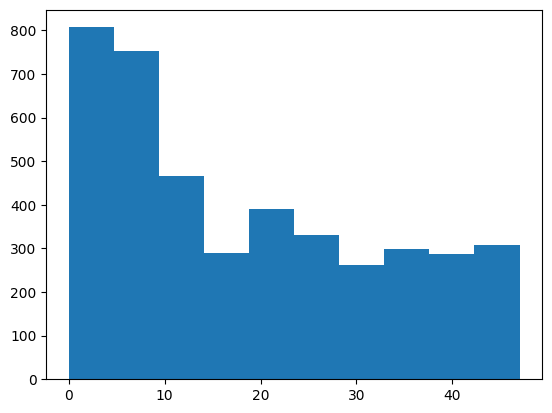

In [669]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

### ノック30：退会ユーザーと継続ユーザーの違いを把握しよう

In [672]:
customer_end = customer_join.filter(pl.col("is_deleted") == 1)
customer_end.select(cs.numeric()).describe()

describe,is_deleted,price,mean,median,max,min,routine_flg,membership_period
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1350.0,1350.0,1350.0,1350.0,1350.0,1350.0,1350.0,1350.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,7.618519
"""std""",0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.322271
"""min""",1.0,6000.0,1.0,1.0,1.0,1.0,0.0,0.0
"""25%""",1.0,6000.0,3.0,3.0,4.0,1.0,0.0,4.0
"""50%""",1.0,7500.0,4.0,4.0,7.0,2.0,0.0,7.0
"""75%""",1.0,10500.0,4.666667,4.5,8.0,2.0,1.0,11.0
"""max""",1.0,10500.0,9.0,9.0,13.0,8.0,1.0,23.0


In [673]:
customer_stay = customer_join.filter(pl.col("is_deleted") == 0)
customer_stay.select(cs.numeric()).describe()

describe,is_deleted,price,mean,median,max,min,routine_flg,membership_period
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2842.0,2842.0,2842.0,2842.0,2842.0,2842.0,2842.0,2842.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,8542.927516,6.030288,6.024279,8.471147,3.62069,0.984166,23.752287
"""std""",0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,14.04593
"""min""",0.0,6000.0,3.166667,3.0,5.0,1.0,0.0,0.0
"""25%""",0.0,6000.0,4.833333,5.0,7.0,2.0,1.0,12.0
"""50%""",0.0,7500.0,5.583333,5.5,8.0,3.0,1.0,24.0
"""75%""",0.0,10500.0,7.181818,7.0,10.0,5.0,1.0,35.0
"""max""",0.0,10500.0,12.0,12.0,14.0,12.0,1.0,47.0


In [674]:
customer_join.write_csv("customer_join.csv")